# Investment Simulation and Analysis

## Overview

This project contains a simulation of a rental property business, alongside an index fund investment. It evaluates and compares the value and cash flows generated from rental properties and reinvested in an index fund over a period of time. The scenario includes two rental properties with different values, rents, and expenses.

## Class Definitions

### `RentalProperty`

This class simulates a single rental property, calculating mortgage payments, annual cash flows, and the evolving property value over time.

#### Key Methods:

- **`__init__`**: Initializes the property with key parameters like value, down payment, loan terms, rental income, etc.
- **`calculate_mortgage_payment`**: Computes the monthly mortgage payment using the given interest rate, loan amount, and term.
- **`calculate_annual_values`**: For a given year, calculates the annual rental income, expenses, property taxes, net cash flow, and updates the property value.

- **Mortgage Payment Equation**:

$$
\text{payment} = \frac{\text{loan\_amount} \times \text{monthly\_rate}}{1 - \left(1 + \text{monthly\_rate}\right)^{-\text{num\_payments}}}
$$

  where `monthly_rate` is the monthly interest rate, and `num_payments` is the total number of payments.
  
- **Annual Property Appreciation**:

$$
\text{current\_property\_value} \times= (1 + \text{property\_appreciation\_rate})
$$

### `IndexFund`

This class simulates an index fund investment, both with and without reinvestment of rental income cash flows.

#### Key Methods:

- **`__init__`**: Initializes the fund with an initial investment and annual return rate.
- **`calculate_value`**: Computes the fund value over a given period, assuming yearly compounding.
- **`calculate_value_with_reinvestment`**: Computes the fund value with annual net cash flows from the rental business reinvested back into the fund.

#### Key Equations:

- **Fund Value Growth**:

$$
\text{new\_value} = \text{previous\_value} \times (1 + \text{annual\_return})
$$

### `RentalBusinessSimulation`

This class runs a multi-year simulation of the rental property business, aggregating the yearly cash flows for all rental properties.

#### Key Methods:

- **`__init__`**: Initializes the simulation with a list of properties and key parameters like inflation rate and simulation duration.
- **`run_simulation`**: Executes the yearly cash flow calculations for all properties and aggregates the results.
- **`get_simulation_results`**: Retrieves the results of the simulation.

### `InvestmentSimulation`

This class runs the index fund simulation with and without reinvestment of rental income.

#### Key Methods:

- **`__init__`**: Initializes the simulation with the rental cash flows, initial investment, and parameters.
- **`run_simulation`**: Executes the calculation of the index fund values over the given period.
- **`get_index_fund_values`**: Retrieves the non-reinvested index fund values.
- **`get_reinvested_fund_values`**: Retrieves the reinvested index fund values.

### `Plotter`

This class visualizes the simulation results using matplotlib.

#### Key Methods:

- **`plot`**: Creates plots for the rental business cash flows, net cash flow, and index fund values.

## Main Function

The `main` function sets up the properties and parameters, runs the simulations, and plots and prints the results.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class RentalProperty:
    def __init__(self, property_value, down_payment, loan_term, interest_rate, annual_rental_income, annual_expenses,
                 annual_property_tax_rate, property_appreciation_rate):
        self.property_value = property_value
        self.down_payment = down_payment
        self.loan_term = loan_term
        self.interest_rate = interest_rate
        self.annual_rental_income = annual_rental_income
        self.annual_expenses = annual_expenses
        self.annual_property_tax_rate = annual_property_tax_rate
        self.property_appreciation_rate = property_appreciation_rate
        self.loan_amount = self.property_value - self.down_payment
        self.mortgage_payment = self.calculate_mortgage_payment()
        self.annual_mortgage_payment = self.mortgage_payment * 12
        self.current_property_value = self.property_value

    def calculate_mortgage_payment(self):
        monthly_rate = self.interest_rate / 12
        num_payments = self.loan_term * 12
        payment = (self.loan_amount * monthly_rate) / (1 - (1 + monthly_rate) ** -num_payments)
        return payment

    def calculate_annual_values(self, year, inflation_rate):
        rental_income = self.annual_rental_income * (1 + inflation_rate) ** (year - 1)
        expenses = self.annual_expenses * (1 + inflation_rate) ** (year - 1)
        self.current_property_value *= (1 + self.property_appreciation_rate)
        property_tax = self.current_property_value * self.annual_property_tax_rate
        net_cash_flow = rental_income - expenses - self.annual_mortgage_payment - property_tax

        return rental_income, expenses, property_tax, net_cash_flow


class IndexFund:
    def __init__(self, initial_investment, annual_return):
        self.initial_investment = initial_investment
        self.annual_return = annual_return
        self.values = [initial_investment]

    def calculate_value(self, years):
        for year in range(1, years + 1):
            new_value = self.values[-1] * (1 + self.annual_return)
            self.values.append(new_value)
        return self.values

    def calculate_value_with_reinvestment(self, rental_cash_flows):
        reinvested_values = [0]
        for year, row in rental_cash_flows.iterrows():
            if year == 0:
                cumulative_fund_value = self.initial_investment * (1 + self.annual_return)
            else:
                cumulative_fund_value = reinvested_values[-1] * (1 + self.annual_return)
            cumulative_fund_value += row['Total Net Cash Flow']
            reinvested_values.append(cumulative_fund_value)
        return reinvested_values


class RentalBusinessSimulation:
    def __init__(self, properties, inflation_rate, annual_index_fund_return, years):
        self.properties = properties
        self.inflation_rate = inflation_rate
        self.annual_index_fund_return = annual_index_fund_return
        self.years = years
        self.rental_cash_flows = pd.DataFrame()

    def run_simulation(self):
        rental_cash_flows_list = []

        for year in range(1, self.years + 1):
            annual_values = []
            for property in self.properties:
                annual_values.append(property.calculate_annual_values(year, self.inflation_rate))

            rental_cash_flows_list.append(self._create_cash_flow_entry(year, annual_values))

        self.rental_cash_flows = pd.DataFrame(rental_cash_flows_list)

    def _create_cash_flow_entry(self, year, annual_values):
        entry = {'Year': year}
        total_net_cash_flow = 0
        total_property_value = 0

        for i, (rental_income, expenses, property_tax, net_cash_flow) in enumerate(annual_values, start=1):
            entry.update({
                f'Rental Income {i}': rental_income,
                f'Expenses {i}': expenses,
                f'Property Tax {i}': property_tax,
                f'Mortgage Payment {i}': self.properties[i - 1].annual_mortgage_payment,
                f'Net Cash Flow {i}': net_cash_flow,
                f'Property Value {i}': self.properties[i - 1].current_property_value
            })
            total_net_cash_flow += net_cash_flow
            total_property_value += self.properties[i - 1].current_property_value

        entry['Total Net Cash Flow'] = total_net_cash_flow
        entry['Total Property Value'] = total_property_value

        return entry

    def get_simulation_results(self):
        return self.rental_cash_flows


class InvestmentSimulation:
    def __init__(self, initial_investment, annual_index_fund_return, rental_cash_flows, years):
        self.index_fund = IndexFund(initial_investment, annual_index_fund_return)
        self.rental_cash_flows = rental_cash_flows
        self.years = years

    def run_simulation(self):
        self.index_fund_values = self.index_fund.calculate_value(self.years)
        self.index_fund_reinvested_values = self.index_fund.calculate_value_with_reinvestment(self.rental_cash_flows)

    def get_index_fund_values(self):
        return self.index_fund_values

    def get_reinvested_fund_values(self):
        return self.index_fund_reinvested_values


class Plotter:
    def __init__(self, rental_cash_flows, index_fund_values, index_fund_reinvested_values):
        self.rental_cash_flows = rental_cash_flows
        self.index_fund_values = index_fund_values
        self.index_fund_reinvested_values = index_fund_reinvested_values

    def plot(self):
        fig, axs = plt.subplots(3, 1, figsize=(18, 18))

        # Plot for Home Rental Business Breakdown
        for col in self.rental_cash_flows.columns:
            if 'Rental Income' in col or 'Expenses' in col or 'Property Tax' in col or 'Mortgage Payment' in col:
                if '1' in col:
                    color = 'gold' if 'Rental Income' in col else 'orange' if 'Expenses' in col else 'cyan' if 'Property Tax' in col else 'magenta' if 'Mortgage Payment' in col else ''
                else:
                    color = 'green' if 'Rental Income' in col else 'red' if 'Expenses' in col else 'blue' if 'Property Tax' in col else 'purple' if 'Mortgage Payment' in col else ''
                axs[0].plot(self.rental_cash_flows['Year'], self.rental_cash_flows[col], label=col, color=color)
        axs[0].set_title('Home Rental Business - Breakdown of Components Over Time')
        axs[0].set_xlabel('Year')
        axs[0].set_ylabel('Cash Flow Components ($)')
        axs[0].legend()
        axs[0].grid(True)

        # Plot for Home Rental Business Net Cash Flow
        axs[1].plot(self.rental_cash_flows['Year'], self.rental_cash_flows['Total Net Cash Flow'],
                    label='Total Net Cash Flow',
                    color='red')
        axs[1].set_title('Home Rental Business - Total Net Cash Flow Over Time')
        axs[1].set_xlabel('Year')
        axs[1].set_ylabel('Cash Flow ($)')
        axs[1].legend()
        axs[1].grid(True)

        # Plot for Index Fund and Index Fund with Reinvested Rental Income
        axs[2].plot(range(1, len(self.index_fund_values)), self.index_fund_values[1:], label='Index Fund Value',
                    color='blue')
        axs[2].plot(range(1, len(self.index_fund_reinvested_values)), self.index_fund_reinvested_values[1:],
                    label='Index Fund with Reinvested Rental Income', color='green')
        axs[2].set_title('Index Fund - Growth Over Time')
        axs[2].set_xlabel('Year')
        axs[2].set_ylabel('Fund Value ($)')
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()


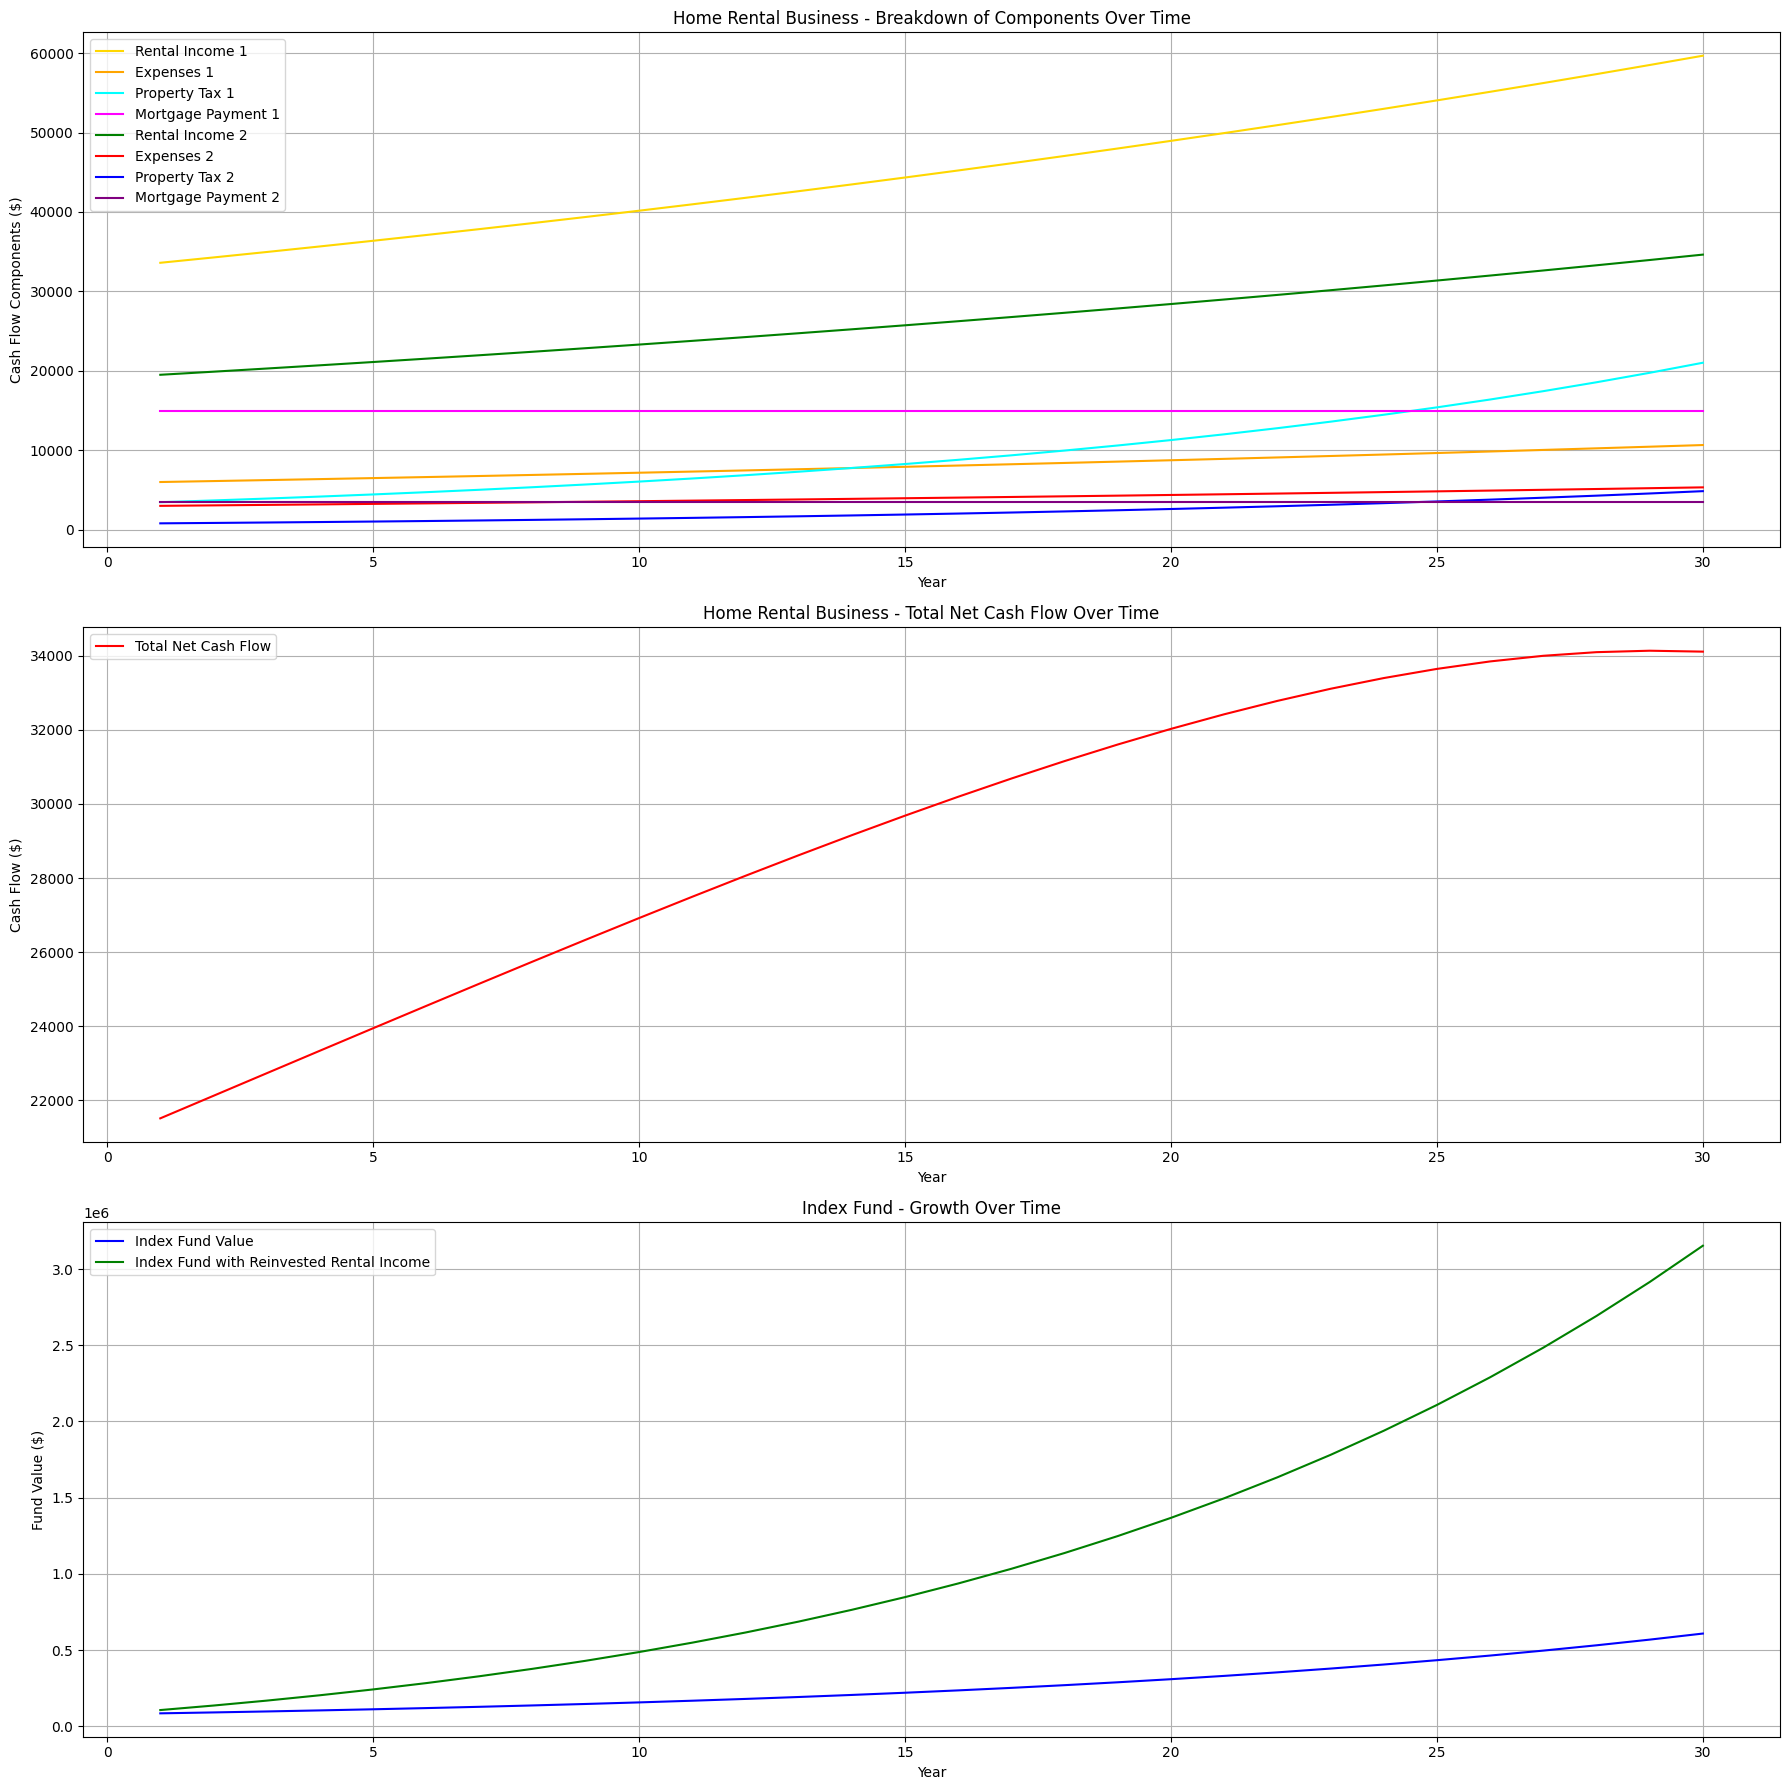

Final Value from Home Rental Business:
 - Property Value 1: $2,101,749.72
 - Property Value 2: $485,019.17
 - Total Property Value: $2,586,768.89
 - Total Net Cash Flow: $876,583.98
 - Combined Total Value: $3,463,352.87

Starting and Ending Values Over 30 Years:
       Category Starting Value Ending Value
Rental Income 1     $33,600.00   $59,668.38
 Property Tax 1      $3,458.65   $21,017.50
     Expenses 1      $6,000.00   $10,655.07
Rental Income 2     $19,500.00   $34,628.97
 Property Tax 2        $798.15    $4,850.19
     Expenses 2      $3,000.00    $5,327.53

Final Value from Index Fund:
 - Index Fund Value: $608,980.40

Final Value from Index Fund with Reinvested Rental Income:
 - Index Fund with Reinvested Rental Income Value: $3,153,047.40

Combined Total Value: $5,739,816.29


In [8]:
def main():
    # Rental Business Inputs
    property_1 = RentalProperty(
        property_value=325000, down_payment=65000, loan_term=30, interest_rate=0.04,
        annual_rental_income=33600, annual_expenses=6000, annual_property_tax_rate=0.01,
        property_appreciation_rate=0.0642
    )

    property_2 = RentalProperty(
        property_value=75000, down_payment=15000, loan_term=30, interest_rate=0.04,
        annual_rental_income=19500, annual_expenses=3000, annual_property_tax_rate=0.01,
        property_appreciation_rate=0.0642
    )

    properties = [property_1, property_2]
    inflation_rate = 0.02
    annual_index_fund_return = 0.07
    years = 30

    # Run rental business simulation
    rental_business_sim = RentalBusinessSimulation(properties, inflation_rate, annual_index_fund_return, years)
    rental_business_sim.run_simulation()
    rental_cash_flows = rental_business_sim.get_simulation_results()

    # Run investment simulations
    initial_investment = property_1.down_payment + property_2.down_payment
    investment_sim = InvestmentSimulation(initial_investment, annual_index_fund_return, rental_cash_flows, years)
    investment_sim.run_simulation()

    index_fund_values = investment_sim.get_index_fund_values()
    index_fund_reinvested_values = investment_sim.get_reinvested_fund_values()

    # Plot the results
    plotter = Plotter(rental_cash_flows, index_fund_values, index_fund_reinvested_values)
    plotter.plot()

    # Print Final Values
    print_final_values(rental_cash_flows, index_fund_values, index_fund_reinvested_values)


def print_final_values(rental_cash_flows, index_fund_values, index_fund_reinvested_values):
    final_property_value_1 = rental_cash_flows.iloc[-1]['Property Value 1']
    final_property_value_2 = rental_cash_flows.iloc[-1]['Property Value 2']
    total_final_property_value = final_property_value_1 + final_property_value_2

    total_net_cash_flow = rental_cash_flows['Total Net Cash Flow'].sum()
    total_value = total_final_property_value + total_net_cash_flow

    # Beginning and Ending Values for Rent, Property Tax, and Expenses
    starting_rent_1 = rental_cash_flows.iloc[0]['Rental Income 1']
    ending_rent_1 = rental_cash_flows.iloc[-1]['Rental Income 1']

    starting_property_tax_1 = rental_cash_flows.iloc[0]['Property Tax 1']
    ending_property_tax_1 = rental_cash_flows.iloc[-1]['Property Tax 1']

    starting_expenses_1 = rental_cash_flows.iloc[0]['Expenses 1']
    ending_expenses_1 = rental_cash_flows.iloc[-1]['Expenses 1']

    starting_rent_2 = rental_cash_flows.iloc[0]['Rental Income 2']
    ending_rent_2 = rental_cash_flows.iloc[-1]['Rental Income 2']

    starting_property_tax_2 = rental_cash_flows.iloc[0]['Property Tax 2']
    ending_property_tax_2 = rental_cash_flows.iloc[-1]['Property Tax 2']

    starting_expenses_2 = rental_cash_flows.iloc[0]['Expenses 2']
    ending_expenses_2 = rental_cash_flows.iloc[-1]['Expenses 2']

    # Final Values for Index Fund and Index Fund with Reinvested Rental Income
    index_fund_final_value = index_fund_values[-1]
    index_fund_reinvested_final_value = index_fund_reinvested_values[-1]

    # Print Final Values
    print(f"Final Value from Home Rental Business:")
    print(f" - Property Value 1: ${final_property_value_1:,.2f}")
    print(f" - Property Value 2: ${final_property_value_2:,.2f}")
    print(f" - Total Property Value: ${total_final_property_value:,.2f}")
    print(f" - Total Net Cash Flow: ${total_net_cash_flow:,.2f}")
    print(f" - Combined Total Value: ${total_value:,.2f}\n")

    # Print Starting and Ending Values Over 30 Years
    print(f"Starting and Ending Values Over 30 Years:")
    # Creating the table for starting and ending values
    data = {
        'Category': ['Rental Income 1', 'Property Tax 1', 'Expenses 1', 'Rental Income 2', 'Property Tax 2',
                     'Expenses 2'],
        'Starting Value': [
            f"${starting_rent_1:,.2f}", f"${starting_property_tax_1:,.2f}", f"${starting_expenses_1:,.2f}",
            f"${starting_rent_2:,.2f}", f"${starting_property_tax_2:,.2f}", f"${starting_expenses_2:,.2f}"
        ],
        'Ending Value': [
            f"${ending_rent_1:,.2f}", f"${ending_property_tax_1:,.2f}", f"${ending_expenses_1:,.2f}",
            f"${ending_rent_2:,.2f}", f"${ending_property_tax_2:,.2f}", f"${ending_expenses_2:,.2f}"
        ]
    }
    values_table = pd.DataFrame(data)
    print(values_table.to_string(index=False))

    # Print Final Values for Index Fund and Index Fund with Reinvested Rental Income
    print(f"\nFinal Value from Index Fund:")
    print(f" - Index Fund Value: ${index_fund_final_value:,.2f}")
    print(f"\nFinal Value from Index Fund with Reinvested Rental Income:")
    print(f" - Index Fund with Reinvested Rental Income Value: ${index_fund_reinvested_final_value:,.2f}")

    # Combined Total Value of Property and Index Fund with Reinvested Rental Income
    combined_total_value = total_final_property_value + index_fund_reinvested_final_value
    print(f"\nCombined Total Value: ${combined_total_value:,.2f}")


# If running in a typical Python environment; Not necessary in Jupyter notebook
if __name__ == "__main__":
    main()
